## MOUNT

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/MSc_project/.MAIN

Mounted at /content/drive
/content/drive/My Drive/MSc_project/.MAIN


## PIPS

In [2]:
!pip install pandas==1.2.4
!pip install xgboost
!pip install lightgbm
!pip install tweet-preprocessor
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.9 MB 11.4 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.3.5
    Uninstalling pandas-1.3.5:
      Successfully uninstalled pandas-1.3.5
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 11.7 MB/s 
     |████████████████████████████████| 6.6 MB 26.2 MB/s 
     |████████████████████████████████| 120 kB 48.4 MB/s 


## DATA LOAD AND CLEAN

In [3]:
import pandas as pd
import os.path

import nltk
from nltk.stem import PorterStemmer # for stemming
from nltk.stem import WordNetLemmatizer # for lemmatization
from nltk.corpus import stopwords
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, Booster
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

import preprocessor as p
import joblib

In [4]:
df=pd.read_csv('user_gender_class/data/gender-classifier-DFE-791531.csv',encoding='latin1')

df.drop(['_unit_id','_last_judgment_at','created','fav_number','profileimage','retweet_count','tweet_coord',
         '_trusted_judgments', 'tweet_count', 'tweet_created', 'tweet_id', 'tweet_location', 'user_timezone', 
         '_golden','_unit_state', 'gender_gold', 'link_color', 'name', 'profile_yn_gold', 'sidebar_color', 
         'profile_yn', 'profile_yn:confidence','gender:confidence'], axis=1, inplace=True)

df.isna().sum()
df.dropna(axis=0,inplace=True)
df['gender'].value_counts()
df['gender'] = df[(df['gender'] == 'female') | (df['gender'] == 'male')]
df['gender'].value_counts()

female    5725
male      5469
Name: gender, dtype: int64

In [5]:
for gen in df['gender']:
  #print(gen)
  if gen=='male':
    df['gender'].replace({'male':'1'},inplace=True)
  elif gen=='female':
    df['gender'].replace({'female':'0'},inplace=True)



df = df[df['gender'].notna()]
print(df['gender'].value_counts())

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

nltk.download('omw-1.4')
remove_rt = lambda x: re.sub('RT @\w+: '," ",x)
rt = lambda x: re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x)

lemma = WordNetLemmatizer()
stopword = nltk.corpus.stopwords.words('english')

def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text

def tokenization(text):
    text = re.split('\W+', text)
    return text


print('now cleaning')

p.set_options(p.OPT.URL, p.OPT.MENTION, p.OPT.NUMBER)
df['clean_description'] = df.description.map(remove_rt).map(rt).map(p.clean).str.lower().apply(lambda x: tokenization(x)).apply(lambda x: remove_stopwords(x))
df['clean_text'] = df.text.map(remove_rt).map(rt).map(p.clean).str.lower().apply(lambda x: tokenization(x)).apply(lambda x: remove_stopwords(x))

df['clean_description'] = df.clean_description.apply(lambda lst: [lemma.lemmatize(word) for word in lst]).str.join(" ")
df['clean_text'] = df.clean_text.apply(lambda lst: [lemma.lemmatize(word) for word in lst]).str.join(" ")

df['texty'] = df['clean_text'] = df.text.map(remove_rt).map(rt).map(p.clean).str.lower()
df['desc'] = df.description.map(remove_rt).map(rt).map(p.clean).str.lower()

n = len(df)
df['sep'] = ['.\n ' for i in range(n)]

df['txt'] = df['desc'] + df['sep'] + df['texty']

df['gender'] = (df['gender']).astype(int)  

0    5725
1    5469
Name: gender, dtype: int64


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


now cleaning


In [6]:
df.txt.head(5)

0    i sing my own rhythm.\n robbie e responds to c...
1    i m the author of novels filled with family dr...
2    louis whining and squealing and all.\n i absol...
3    mobile guy ers shazam google kleiner perkins y...
4    ricky wilson the best frontman kaiser chiefs t...
Name: txt, dtype: object

## ROBERTA XLM

### PIPS

In [13]:
!pip install transformers
!pip install wget
!pip install pytorch-pretrained-bert
!pip install urllib3
!pip install --upgrade simpletransformers
!pip install --upgrade botocore==1.23.26
!pip install --upgrade urllib3==1.22.0
!pip install memory_profiler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached botocore-1.27.66-py3-none-any.whl (9.1 MB)
  Using cached urllib3-1.26.12-py2.py3-none-any.whl (140 kB)
  Using cached urllib3-1.25.11-py2.py3-none-any.whl (127 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.22
    Uninstalling urllib3-1.22:
      Successfully uninstalled urllib3-1.22
  Attempting uninstall: botocore
    Found existing installation: botocore 1.23.26
    Uninstalling botocore-1.23.26:
      Successfully uninstalled botocore-1.23.26


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached botocore-1.23.26-py3-none-any.whl (8.5 MB)
  Attempting uninstall: botocore
    Found existing installation: botocore 1.27.66
    Uninstalling botocore-1.27.66:
      Successfully uninstalled botocore-1.27.66
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
boto3 1.24.66 requires botocore<1.28.0,>=1.27.66, but you have botocore 1.23.26 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached urllib3-1.22-py2.py3-none-any.whl (132 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.25.11
    Uninstalling urllib3-1.25.11:
      Successfully uninstalled urllib3-1.25.11
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
responses 0.18.0 requires urllib3>=1.25.10, but you have urllib3 1.22 which is incompatible.
botocore 1.23.26 requires urllib3<1.27,>=1.25.4, but you have urllib3 1.22 which is incompatible.
boto3 1.24.66 requires botocore<1.28.0,>=1.27.66, but you have botocore 1.23.26 which is incompatible.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
# If there's a GPU available...
import torch

if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

import wget
import os
import os.path
import torch, gc, random, datasets
from transformers.file_utils import is_tf_available, is_torch_available
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import AutoConfig
%load_ext memory_profiler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_error, mean_absolute_error
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-16GB


### trainer func

In [ ]:
def Classification_with_Transformer(model_name: str, Data: pd.Series, Target:pd.Series, test_size: np.float64, max_length: int, num_labels: int, num_epochs: int):

    # Make data
    X = Data
    y = Target


    # Split Data
    X_train, X_test, y_train, y_test = train_test_split(X.tolist(), y, test_size=test_size)

    # Call the Tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Encode the text
    train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=max_length)
    valid_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=max_length)



    class MakeTorchData(torch.utils.data.Dataset):
          def __init__(self, encodings, labels):
              self.encodings = encodings
              self.labels = labels

          def __getitem__(self, idx):
              item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
              item["labels"] = torch.tensor([self.labels[idx]])
              item["labels"] = float(item["labels"])
              return item

          def __len__(self):
              return len(self.labels)

    # convert our tokenized data into a torch Dataset
    train_dataset = MakeTorchData(train_encodings, y_train.ravel())
    valid_dataset = MakeTorchData(valid_encodings, y_test.ravel())


    # Call Model
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = num_labels).to("cuda") # np.log(1000)

    def compute_metrics(pred):
    logits, labels = eval_pred
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


    def compute_metrics_for_regression(eval_pred):
          logits, labels = eval_pred
          # print("Logits:", logits[0:5])
          # print("Labels:", labels[0:5])
          # logits = inverse_sigmoid(logits)
          labels = labels.reshape(-1, 1)
          
          print("Logits:", logits[0:5])
          print("Labels:", labels[0:5])
          # print("Labels:", labels)

          mse = mean_squared_error(labels, logits)
          rmse = mean_squared_error(labels, logits, squared=False)
          mae = mean_absolute_error(labels, logits)
          r2 = r2_score(labels, logits)
          # smape = 1/len(labels) * np.sum(2 * np.abs(logits-labels) / (np.abs(labels) + np.abs(logits))*100)
          single_squared_errors = ((logits - labels).flatten()**2).tolist()
          accuracy = sum([1 for e in single_squared_errors if e < 0.25]) / len(single_squared_errors)
          
          return {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2, "accuracy": accuracy}

    # Specifiy the arguments for the trainer  
    training_args = TrainingArguments(
        output_dir=f'user_gender_class{os.path.sep}results',          # output directory
        num_train_epochs=num_epochs,     # total number of training epochs
        per_device_train_batch_size = 32,   # batch size per device during training
        per_device_eval_batch_size=20,   # batch size for evaluation
        weight_decay=0.01,               # strength of weight decay
        learning_rate=2e-5,
        # logging_dir='./logs',            # directory for storing logs
        save_total_limit=10,
        load_best_model_at_end=True,     # load the best model when finished training (default metric is loss)
        metric_for_best_model = 'accuracy',    # select the base metrics
        evaluation_strategy="epoch",
        save_strategy="epoch",
    ) 

    # Call the Trainer
    trainer = Trainer(
        model=model,                         # the instantiated Transformers model to be trained
        args=training_args,                  # training arguments, defined above
        train_dataset=train_dataset,         # training dataset
        eval_dataset=valid_dataset,          # evaluation dataset
        compute_metrics=compute_metrics,     # the callback that computes metrics of interest
    )

    # Train the model
    trainer.train()
    
    # Call the summary
    trainer.evaluate()



    return trainer, model

In [ ]:
X = df.text_clean

df['labels'] = df['gender']
y = df.labels

%%time
%%memit
bert_trainer, bert_model = Classification_with_Transformer(model_name = 'roberta-base', 
                                                                 Data = X, 
                                                                 Target = y.astype(float), 
                                                                 test_size = 0.2, 
                                                                 max_length = 256, 
                                                                 num_labels = 2, 
                                                                 num_epochs = 3)

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score

# Split test and train data using 25% of the dataset for validation purposes
x_train, x_test, y_train, y_test = train_test_split(df['clean_text'], 
                                                      df['gender'], test_size=0.25, shuffle=True, random_state=42)

In [ ]:
# Create a Pipeline with the TfidfVectorizer and LogisticRegression model
LR_pipeline = Pipeline(steps = [('tf', TfidfVectorizer()), 
                                ('lgrg', LogisticRegression())]) # initialize TfidfVectorizer and LogisticRegression


# Create Parameter Grid
pgrid_lgrg = {
 'tf__max_features' : [1000, 2000, 3000],
 'tf__ngram_range' : [(1,1),(1,2)],
 'tf__use_idf' : [True, False],
 'lgrg__penalty' : ['l1', 'l2', 'elasticnet', 'none'],
 'lgrg__class_weight' : ['balanced', None]
}

# Apply GridSearch to Pipeline to find the best parameters
gs_lgrg = GridSearchCV(LR_pipeline, pgrid_lgrg, cv=2, n_jobs=-1, verbose=2)

gs_lgrg.fit(x_train, y_train) # Train LR model

gs_lgrg.best_params_

Score of train set 0.7372245384157237
Score of test set 0.5834226509467667


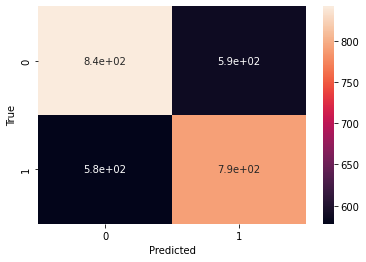

Accuracy of LR model 0.5834226509467667
              precision    recall  f1-score   support

      true_y       0.59      0.59      0.59      1430
 predicted_y       0.57      0.58      0.58      1369

    accuracy                           0.58      2799
   macro avg       0.58      0.58      0.58      2799
weighted avg       0.58      0.58      0.58      2799



In [ ]:
print('Score of train set', gs_lgrg.score(x_train, y_train))
print('Score of test set',gs_lgrg.score(x_test, y_test))

LR_pred = gs_lgrg.predict(x_test) # Predict on validation data

data = {'true_y': y_test,
       'predicted_y': LR_pred}
df_pred = pd.DataFrame(data, columns=['true_y','predicted_y'])
confusion_matrix = pd.crosstab(df_pred['true_y'], df_pred['predicted_y'], rownames=['True'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True)
plt.show()

print('Accuracy of LR model', accuracy_score(y_test, LR_pred))

print(classification_report(y_test, LR_pred, target_names=target_names))

## ROBERTA SIMPLE


In [ ]:
!pip install --upgrade transformers
!pip install simpletransformers

In [ ]:
import tensorflow as tf
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from simpletransformers.classification import ClassificationModel, ClassificationArgs

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.2, stratify=df['gender'], random_state=42)

model_args = ClassificationArgs(num_train_epochs=1, overwrite_output_dir=True, manual_seed=42, silent=True)

model = ClassificationModel(model_type='roberta', model_name='roberta-base', use_cuda=True, num_labels=2, 
                            args=model_args)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

In [ ]:
model.train_model(train_df)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:602: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


In [ ]:
result, model_outputs, wrong_predictions = model.eval_model(valid_df)

## BERT

In [7]:
import tensorflow as tf
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [8]:
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

import pandas as pd
import random, time
from babel.dates import format_date, format_datetime, format_time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score


import torch
from torch import Tensor
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F

import transformers, os
from transformers import BertModel, AutoModel, AdamW, get_linear_schedule_with_warmup, BertTokenizer, BertForSequenceClassification
from transformers import RobertaModel, AutoModel, AdamW, get_linear_schedule_with_warmup, RobertaTokenizer, RobertaForSequenceClassification
from transformers import AutoTokenizer, RobertaConfig

### ROBERTA MODEL

#### PRETRAINED ROBERTA

In [ ]:
df['gender'] = (df['gender']).astype(int)


# Split test and train data using 25% of the dataset for validation purposes
x_train, x_test, y_train, y_test = train_test_split(df['clean_text'], 
                                                      df['gender'], test_size=0.2, shuffle=True, random_state=42)

# Obtain a 10% test set from train set
X_train_Transformer, X_val_Transformer, y_train_Transformer, y_val_Transformer = train_test_split(
                                                    x_train, y_train, test_size=0.20, random_state=42)

model_name = 'roberta-base'
SEQ_LEN = 256
batch_size = 16
epochs = 5
learning_rate = 2e-5 # Controls how large a step is taken when updating model weights during training.
steps_per_epoch = int(len(df)/16)
num_workers = 3

def get_split(text1):
    '''Get split of the text with 200 char lenght'''
    l_total = []
    l_parcial = []
    if len(text1.split())//150 >0:
        n = len(text1.split())//150
    else: 
        n = 1
    for w in range(n):
        if w == 0:
            l_parcial = text1.split()[:200]
            l_total.append(" ".join(l_parcial))
        else:
            l_parcial = text1.split()[w*150:w*150 + 200]
            l_total.append(" ".join(l_parcial))
    return str(l_total)

# Splits train and validation sets to be feed to the transformer which only accepts 512 tokens maximum
split_train_text = [get_split(t) for t in X_train_Transformer]
split_valid_text = [get_split(t) for t in X_val_Transformer]
split_test_text = [get_split(t) for t in x_test]


# Load the RoBERTa tokenizer and tokenize the data
print('Loading ROBERTA tokenizer...')
tokenizer = RobertaTokenizer.from_pretrained(model_name, do_lower_case=True)

trencoding = tokenizer.batch_encode_plus(
  list(split_train_text),
  max_length=SEQ_LEN,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=True,
  truncation=True,
  padding='longest',
  return_attention_mask=True,
)

valencoding = tokenizer.batch_encode_plus(
  list(split_valid_text),
  max_length=SEQ_LEN,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=True,
  truncation=True,
  padding='longest',
  return_attention_mask=True,
)


testencoding = tokenizer.batch_encode_plus(
  list(split_test_text),
  max_length=SEQ_LEN,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=True,
  truncation=True,
  padding='longest',
  return_attention_mask=True,
)

#compute the class weights
class_wts = compute_class_weight(class_weight='balanced', classes = np.unique(df['gender'].values.tolist()), 
                                 y = df['gender'])

#print(class_wts)

# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 
cross_entropy  = nn.CrossEntropyLoss(weight=weights)

def loadData(prep_df, batch_size, num_workers, sampler):
    
    return  DataLoader(
            prep_df,
            batch_size=batch_size,
            num_workers=num_workers,
            sampler=sampler,
            pin_memory=True
        )

## convert lists to tensors
train_seq = torch.tensor(trencoding['input_ids'])
train_mask = torch.tensor(trencoding['attention_mask'])
train_token_ids = torch.tensor(trencoding['token_type_ids'])
train_y = torch.tensor(y_train_Transformer.tolist())

val_seq = torch.tensor(valencoding['input_ids'])
val_mask = torch.tensor(valencoding['attention_mask'])
val_token_ids = torch.tensor(valencoding['token_type_ids'])
val_y = torch.tensor(y_val_Transformer.tolist())

test_seq = torch.tensor(testencoding['input_ids'])
test_mask = torch.tensor(testencoding['attention_mask'])
test_token_ids = torch.tensor(testencoding['token_type_ids'])
test_y = torch.tensor(y_test.tolist())

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_token_ids, train_y)
# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)
# Train Data Loader
traindata = loadData(train_data, batch_size, num_workers, train_sampler)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_token_ids, val_y)
# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)
# Val Data Loader
valdata = loadData(val_data, batch_size, num_workers, val_sampler)

# wrap tensors
test_data = TensorDataset(test_seq, test_mask, test_token_ids, test_y)
# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)
# Val Data Loader
testdata = loadData(test_data, batch_size, num_workers, test_sampler)


print('Number of data in the train set', len(traindata))
print('Number of data in the validation set', len(valdata))
print('Number of data in the test set', len(testdata))


class_names = np.unique(df['gender'])
print('Downloading the ROBERTA custom model...')
config = RobertaConfig.from_pretrained('roberta-base')


model.to(device) # Model to GPU.

#optimizer parameters
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [{'params': [p for n, p in param_optimizer 
                                    if not any(nd in n for nd in no_decay)],'weight_decay':0.001},
                        {'params': [p for n, p in param_optimizer 
                                    if any(nd in n for nd in no_decay)],'weight_decay':0.0}]

print('Preparing the optimizer...')
#optimizer 
optimizer = AdamW(optimizer_parameters, lr=learning_rate)
steps = steps_per_epoch
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = steps
)


#### BAD ROBERTA

In [ ]:
df['gender'] = (df['gender']).astype(int)


# Split test and train data using 25% of the dataset for validation purposes
x_train, x_test, y_train, y_test = train_test_split(df['clean_text'], 
                                                      df['gender'], test_size=0.2, shuffle=True, random_state=42)

# Obtain a 10% test set from train set
X_train_Transformer, X_val_Transformer, y_train_Transformer, y_val_Transformer = train_test_split(
                                                    x_train, y_train, test_size=0.20, random_state=42)

model_name = 'xlm-roberta-base'
SEQ_LEN = 256
batch_size = 16
epochs = 5
learning_rate = 2e-5 # Controls how large a step is taken when updating model weights during training.
steps_per_epoch = int(len(df)/16)
num_workers = 3

def get_split(text1):
    '''Get split of the text with 200 char lenght'''
    l_total = []
    l_parcial = []
    if len(text1.split())//150 >0:
        n = len(text1.split())//150
    else: 
        n = 1
    for w in range(n):
        if w == 0:
            l_parcial = text1.split()[:200]
            l_total.append(" ".join(l_parcial))
        else:
            l_parcial = text1.split()[w*150:w*150 + 200]
            l_total.append(" ".join(l_parcial))
    return str(l_total)

# Splits train and validation sets to be feed to the transformer which only accepts 512 tokens maximum
split_train_text = [get_split(t) for t in X_train_Transformer]
split_valid_text = [get_split(t) for t in X_val_Transformer]
split_test_text = [get_split(t) for t in x_test]


# Load the RoBERTa tokenizer and tokenize the data
print('Loading ROBERTA tokenizer...')
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True)

trencoding = tokenizer.batch_encode_plus(
  list(split_train_text),
  max_length=SEQ_LEN,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=True,
  truncation=True,
  padding='longest',
  return_attention_mask=True,
)

valencoding = tokenizer.batch_encode_plus(
  list(split_valid_text),
  max_length=SEQ_LEN,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=True,
  truncation=True,
  padding='longest',
  return_attention_mask=True,
)


testencoding = tokenizer.batch_encode_plus(
  list(split_test_text),
  max_length=SEQ_LEN,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=True,
  truncation=True,
  padding='longest',
  return_attention_mask=True,
)

#compute the class weights
class_wts = compute_class_weight(class_weight='balanced', classes = np.unique(df['gender'].values.tolist()), 
                                 y = df['gender'])

#print(class_wts)

# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 
cross_entropy  = nn.CrossEntropyLoss(weight=weights)

def loadData(prep_df, batch_size, num_workers, sampler):
    
    return  DataLoader(
            prep_df,
            batch_size=batch_size,
            num_workers=num_workers,
            sampler=sampler,
            pin_memory=True
        )

## convert lists to tensors
train_seq = torch.tensor(trencoding['input_ids'])
train_mask = torch.tensor(trencoding['attention_mask'])
train_token_ids = torch.tensor(trencoding['token_type_ids'])
train_y = torch.tensor(y_train_Transformer.tolist())

val_seq = torch.tensor(valencoding['input_ids'])
val_mask = torch.tensor(valencoding['attention_mask'])
val_token_ids = torch.tensor(valencoding['token_type_ids'])
val_y = torch.tensor(y_val_Transformer.tolist())

test_seq = torch.tensor(testencoding['input_ids'])
test_mask = torch.tensor(testencoding['attention_mask'])
test_token_ids = torch.tensor(testencoding['token_type_ids'])
test_y = torch.tensor(y_test.tolist())

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_token_ids, train_y)
# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)
# Train Data Loader
traindata = loadData(train_data, batch_size, num_workers, train_sampler)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_token_ids, val_y)
# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)
# Val Data Loader
valdata = loadData(val_data, batch_size, num_workers, val_sampler)

# wrap tensors
test_data = TensorDataset(test_seq, test_mask, test_token_ids, test_y)
# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)
# Val Data Loader
testdata = loadData(test_data, batch_size, num_workers, test_sampler)


print('Number of data in the train set', len(traindata))
print('Number of data in the validation set', len(valdata))
print('Number of data in the test set', len(testdata))

class Roberta_Arch(nn.Module):
    
    def __init__(self, n_classes, freeze_bert=False):
        
        super(Roberta_Arch,self).__init__()
        # Instantiating BERT model object
        self.bert = RobertaModel.from_pretrained(model_name, return_dict=False)
        
        # Freeze bert layers
        if freeze_bert:
            for p in self.bert.parameters():
                p.requires_grad = False
                
        self.bert_drop_1 = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size) # (768, 64)
        self.bn = nn.BatchNorm1d(768) # (768)
        self.bert_drop_2 = nn.Dropout(0.25)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes) # (768,2)


    def forward(self, input_ids, attention_mask, token_type_ids):
        _, output = self.bert(
            input_ids = input_ids,
            attention_mask = attention_mask,
            token_type_ids = token_type_ids
        )
        output = self.bert_drop_1(output)
        output = self.fc(output)
        output = self.bn(output)
        output = self.bert_drop_2(output)
        output = self.out(output)        
        return output

class_names = np.unique(df['gender'])
print('Downloading the ROBERTA custom model...')
model = Roberta_Arch(len(class_names))
model.to(device) # Model to GPU.

#optimizer parameters
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [{'params': [p for n, p in param_optimizer 
                                    if not any(nd in n for nd in no_decay)],'weight_decay':0.001},
                        {'params': [p for n, p in param_optimizer 
                                    if any(nd in n for nd in no_decay)],'weight_decay':0.0}]

print('Preparing the optimizer...')
#optimizer 
optimizer = AdamW(optimizer_parameters, lr=learning_rate)
steps = steps_per_epoch
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = steps
)


Loading ROBERTA tokenizer...
Number of data in the train set 448
Number of data in the validation set 112
Number of data in the test set 140


You are using a model of type xlm-roberta to instantiate a model of type roberta. This is not supported for all configurations of models and can yield errors.
Some weights of the model checkpoint at xlm-roberta-base were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Preparing the optimizer...


### BERT MODEL

In [9]:
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

import pandas as pd
import random, time
from babel.dates import format_date, format_datetime, format_time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score


import torch
from torch import Tensor
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F

import transformers, os
from transformers import BertModel, AutoModel, AdamW, get_linear_schedule_with_warmup, BertTokenizer, BertForSequenceClassification
from transformers import RobertaModel, AutoModel, AdamW, get_linear_schedule_with_warmup, RobertaTokenizer, RobertaForSequenceClassification
from transformers import AutoTokenizer, RobertaConfig

In [10]:
df['gender'] = (df['gender']).astype(int)


# Split test and train data using 25% of the dataset for validation purposes
x_train, x_test, y_train, y_test = train_test_split(df['txt'], 
                                                      df['gender'], test_size=0.2, shuffle=True, random_state=42)

# Obtain a 10% test set from train set
X_train_Transformer, X_val_Transformer, y_train_Transformer, y_val_Transformer = train_test_split(
                                                    x_train, y_train, test_size=0.20, random_state=42)

model_name = 'bert-base-uncased'
SEQ_LEN = 512
batch_size = 16
epochs = 2
learning_rate = 1e-5 # Controls how large a step is taken when updating model weights during training.
steps_per_epoch = int(len(df)/16)
num_workers = 3

def get_split(text1):
    '''Get split of the text with 200 char lenght'''
    l_total = []
    l_parcial = []
    if len(text1.split())//150 >0:
        n = len(text1.split())//150
    else: 
        n = 1
    for w in range(n):
        if w == 0:
            l_parcial = text1.split()[:200]
            l_total.append(" ".join(l_parcial))
        else:
            l_parcial = text1.split()[w*150:w*150 + 200]
            l_total.append(" ".join(l_parcial))
    return str(l_total)

# Splits train and validation sets to be feed to the transformer which only accepts 512 tokens maximum
split_train_text = [get_split(t) for t in X_train_Transformer]
split_valid_text = [get_split(t) for t in X_val_Transformer]
split_test_text = [get_split(t) for t in x_test]


# Load the RoBERTa tokenizer and tokenize the data
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=True)

trencoding = tokenizer.batch_encode_plus(
  list(split_train_text),
  max_length=SEQ_LEN,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=True,
  truncation=True,
  padding='longest',
  return_attention_mask=True,
)

valencoding = tokenizer.batch_encode_plus(
  list(split_valid_text),
  max_length=SEQ_LEN,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=True,
  truncation=True,
  padding='longest',
  return_attention_mask=True,
)


testencoding = tokenizer.batch_encode_plus(
  list(split_test_text),
  max_length=SEQ_LEN,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=True,
  truncation=True,
  padding='longest',
  return_attention_mask=True,
)

#compute the class weights
class_wts = compute_class_weight(class_weight='balanced', classes = np.unique(df['gender'].values.tolist()), 
                                 y = df['gender'])

#print(class_wts)

# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights) 
cross_entropy  = nn.CrossEntropyLoss(weight=weights)

def loadData(prep_df, batch_size, num_workers, sampler):
    
    return  DataLoader(
            prep_df,
            batch_size=batch_size,
            num_workers=num_workers,
            sampler=sampler,
            pin_memory=True
        )

## convert lists to tensors
train_seq = torch.tensor(trencoding['input_ids'])
train_mask = torch.tensor(trencoding['attention_mask'])
train_token_ids = torch.tensor(trencoding['token_type_ids'])
train_y = torch.tensor(y_train_Transformer.tolist())

val_seq = torch.tensor(valencoding['input_ids'])
val_mask = torch.tensor(valencoding['attention_mask'])
val_token_ids = torch.tensor(valencoding['token_type_ids'])
val_y = torch.tensor(y_val_Transformer.tolist())

test_seq = torch.tensor(testencoding['input_ids'])
test_mask = torch.tensor(testencoding['attention_mask'])
test_token_ids = torch.tensor(testencoding['token_type_ids'])
test_y = torch.tensor(y_test.tolist())

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_token_ids, train_y)
# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)
# Train Data Loader
traindata = loadData(train_data, batch_size, num_workers, train_sampler)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_token_ids, val_y)
# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)
# Val Data Loader
valdata = loadData(val_data, batch_size, num_workers, val_sampler)

# wrap tensors
test_data = TensorDataset(test_seq, test_mask, test_token_ids, test_y)
# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)
# Val Data Loader
testdata = loadData(test_data, batch_size, num_workers, test_sampler)


print('Number of data in the train set', len(traindata))
print('Number of data in the validation set', len(valdata))
print('Number of data in the test set', len(testdata))

class BERT_Arch(nn.Module):
    
    def __init__(self, n_classes, freeze_bert=False):
        
        super(BERT_Arch,self).__init__()
        # Instantiating BERT model object
        self.bert = BertModel.from_pretrained(model_name, return_dict=False)
        
        # Freeze bert layers
        if freeze_bert:
            for p in self.bert.parameters():
                p.requires_grad = False
                
        self.bert_drop_1 = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size) # (768, 64)
        self.bn = nn.BatchNorm1d(768) # (768)
        self.bert_drop_2 = nn.Dropout(0.25)
        self.out = nn.Linear(self.bert.config.hidden_size, 2) # (768,2)


    def forward(self, input_ids, attention_mask, token_type_ids):
        _, output = self.bert(
            input_ids = input_ids,
            attention_mask = attention_mask,
            token_type_ids = token_type_ids
        )
        output = self.bert_drop_1(output)
        output = self.fc(output)
        output = self.bn(output)
        output = self.bert_drop_2(output)
        output = self.out(output)        
        return output

class_names = np.unique(df['gender'])
print('Downloading the BERT custom model...')
model = BERT_Arch(len(class_names))
model.to(device) # Model to GPU.

#optimizer parameters
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [{'params': [p for n, p in param_optimizer 
                                    if not any(nd in n for nd in no_decay)],'weight_decay':0.001},
                        {'params': [p for n, p in param_optimizer 
                                    if any(nd in n for nd in no_decay)],'weight_decay':0.0}]

print('Preparing the optimizer...')
#optimizer 
optimizer = AdamW(optimizer_parameters, lr=learning_rate)
steps = steps_per_epoch
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = steps
)


Loading BERT tokenizer...


Number of data in the train set 448
Number of data in the validation set 112
Number of data in the test set 140


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Preparing the optimizer...


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


### TRAINING AND EVAL FUNCS

In [11]:
# function to train the bert model
def trainMODEL():
  
    print('Training...')
    model.train()
    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds=[]

    # iterate over batches
    for step, batch in enumerate(traindata):
    
        # progress update after every 50 batches.
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(traindata)))

        if torch.cuda.is_available():
            # push the batch to gpu
            batch = [r.to(device) for r in batch]

        sent_id, mask, token_type_ids, labels = batch
        # clear previously calculated gradients 
        model.zero_grad()        
        # get model predictions for the current batch
        preds = model(sent_id, mask, token_type_ids)
        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)
        # add on to the total loss
        total_loss = total_loss + loss.item()
        # backward pass to calculate the gradients
        loss.backward()
        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # update parameters
        optimizer.step()
        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()
        # append the model predictions
        total_preds.append(preds)
        
        torch.cuda.empty_cache()

    # compute the training loss of the epoch
    avg_loss = total_loss / len(traindata)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    #returns the loss and predictions
    return avg_loss, total_preds

# function for evaluating the model
def evaluate():
  
    print("\nEvaluating...")
    t0 = time.time()
    
    model.eval() # deactivate dropout layers
    total_loss, total_accuracy = 0, 0
    
    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step, batch in enumerate(valdata):
        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(valdata)))

        if torch.cuda.is_available():
            # push the batch to gpu
            batch = [t.to(device) for t in batch]

        sent_id, mask, token_type_ids, labels = batch

        # deactivate autograd
        with torch.no_grad(): # Dont store any previous computations, thus freeing GPU space

            # model predictions
            preds = model(sent_id, mask, token_type_ids)
            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds, labels)
            total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)

        torch.cuda.empty_cache()
    # compute the validation loss of the epoch
    avg_loss = total_loss / len(valdata) 
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [12]:
# set initial loss to infinite
best_valid_loss = float('inf')

# Empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

# for each epoch perform training and evaluation
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = trainMODEL()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    print('Evaluation done for epoch {}'.format(epoch + 1))
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        print('Saving model...')
        torch.save(model.state_dict(), 'bert_weights.pt') # Save model weight's (you can also save it in .bin format)
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 2
Training...
  Batch    50  of    448.
  Batch   100  of    448.
  Batch   150  of    448.
  Batch   200  of    448.
  Batch   250  of    448.
  Batch   300  of    448.
  Batch   350  of    448.
  Batch   400  of    448.

Evaluating...
  Batch    50  of    112.
  Batch   100  of    112.
Evaluation done for epoch 1
Saving model...

Training Loss: 0.679
Validation Loss: 0.573

 Epoch 2 / 2
Training...
  Batch    50  of    448.
  Batch   100  of    448.
  Batch   150  of    448.
  Batch   200  of    448.
  Batch   250  of    448.
  Batch   300  of    448.
  Batch   350  of    448.
  Batch   400  of    448.

Evaluating...
  Batch    50  of    112.
  Batch   100  of    112.
Evaluation done for epoch 2

Training Loss: 0.576
Validation Loss: 0.577


In [13]:
print('\nTest Set...')

test_preds = []

print('Total batches:', len(testdata))

for fold_index in range(0, 3):
    
    print('\nFold Model', fold_index)
    
    # Load the fold model
    path_model = 'bert_weights.pt'
    model.load_state_dict(torch.load(path_model))

    # Send the model to the GPU
    model.to(device)

    stacked_val_labels = []
    
    # Put the model in evaluation mode.
    model.eval()

    # Turn off the gradient calculations.
    # This tells the model not to compute or store gradients.
    # This step saves memory and speeds up validation.
    torch.set_grad_enabled(False)


    # Reset the total loss for this epoch.
    total_val_loss = 0

    for j, test_batch in enumerate(testdata):

        inference_status = 'Batch ' + str(j + 1)

        print(inference_status, end='\r')

        b_input_ids = test_batch[0].to(device)
        b_input_mask = test_batch[1].to(device)
        b_token_type_ids = test_batch[2].to(device)
        b_test_y = test_batch[3].to(device)


        outputs = model(b_input_ids, 
                        attention_mask=b_input_mask,
                        token_type_ids=b_token_type_ids)

        # Get the preds
        preds = outputs[0]

        # Move preds to the CPU
        val_preds = preds.detach().cpu().numpy()
        
        #true_labels.append(b_test_y.to('cpu').numpy().flatten())
        
        # Stack the predictions.
        if j == 0:  # first batch
            stacked_val_preds = val_preds
            
        else:
            stacked_val_preds = np.vstack((stacked_val_preds, val_preds))
            
    test_preds.append(stacked_val_preds)
    
            
print('\nPrediction complete.')


Test Set...
Total batches: 140

Fold Model 0

Fold Model 1
Batch 140
Fold Model 2
Batch 140
Prediction complete.


[0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0]


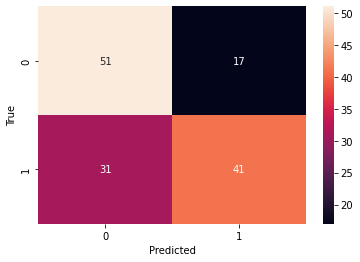

----
Accuracy of BERT model 0.6571428571428571
----
              precision    recall  f1-score   support

      true_y       0.62      0.75      0.68        68
 predicted_y       0.71      0.57      0.63        72

    accuracy                           0.66       140
   macro avg       0.66      0.66      0.66       140
weighted avg       0.67      0.66      0.65       140



In [14]:
# Sum the predictions of all fold models
for i, item in enumerate(test_preds):
    if i == 0:
        preds = item
    else:
        # Sum the matrices
        preds = item + preds

# Average the predictions
avg_preds = preds/(len(test_preds))

#print(preds)
#print()
#print(avg_preds)

# Take the argmax. 
# This returns the column index of the max value in each row.
test_predictions = np.argmax(avg_preds, axis=1)

true_y = []
for j, test_batch in enumerate(testdata):
    true_y.append(int(test_batch[3][0].numpy().flatten()))
print(true_y)

# Accuracy and classification report 
target_names = ['true_y', 'predicted_y']

data = {'true_y': true_y,
       'predicted_y': test_predictions}

df_pred_BERT = pd.DataFrame(data, columns=['true_y','predicted_y'])

confusion_matrix = pd.crosstab(df_pred_BERT['true_y'], df_pred_BERT['predicted_y'], rownames=['True'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True)
plt.show()

print('----')
print('Accuracy of BERT model', accuracy_score(true_y, test_predictions))
print('----')

print(classification_report(true_y, test_predictions, target_names=target_names))

In [18]:
torch.save(model.state_dict(), 'user_gender_class/gender_model')

In [25]:
## LOAD AFTERTRAINING
from transformers import BertModel, BertTokenizer, BertConfig


class BERT_Arch(nn.Module):
    
    def __init__(self, n_classes, freeze_bert=False):
        
        super(BERT_Arch,self).__init__()
        # Instantiating BERT model object
        model_path = 'user_gender_class/gender_model'
        self.bert = BertModel.from_pretrained(model_name, return_dict=False)
        self.load_state_dict(torch.load(model_path))
        
        # Freeze bert layers
        if freeze_bert:
            for p in self.bert.parameters():
                p.requires_grad = False
                
        self.bert_drop_1 = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, self.bert.config.hidden_size) # (768, 64)
        self.bn = nn.BatchNorm1d(768) # (768)
        self.bert_drop_2 = nn.Dropout(0.25)
        self.out = nn.Linear(self.bert.config.hidden_size, 2) # (768,2)


    def forward(self, input_ids, attention_mask, token_type_ids):
        _, output = self.bert(
            input_ids = input_ids,
            attention_mask = attention_mask,
            token_type_ids = token_type_ids
        )
        output = self.bert_drop_1(output)
        output = self.fc(output)
        output = self.bn(output)
        output = self.bert_drop_2(output)
        output = self.out(output)        
        return output

class_names = np.unique(df['gender'])
print('Downloading the BERT custom model...')
x_model = BERT_Arch(2)

#optimizer parameters
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [{'params': [p for n, p in param_optimizer 
                                    if not any(nd in n for nd in no_decay)],'weight_decay':0.001},
                        {'params': [p for n, p in param_optimizer 
                                    if any(nd in n for nd in no_decay)],'weight_decay':0.0}]

print('Preparing the optimizer...')
#optimizer 
optimizer = AdamW(optimizer_parameters, lr=learning_rate)
steps = steps_per_epoch
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = steps
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


RuntimeError: ignored

## ROBERTA NOT SIMPLE

In [ ]:
import tensorflow as tf
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


In [ ]:
import pandas as pd
import numpy as np
import json, re
from tqdm import tqdm_notebook
from uuid import uuid4

## Torch Modules
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import transformers

In [ ]:
# loading pre-trained models
from transformers import (
    BertForSequenceClassification,
#     TFBertForSequenceClassification, 
                          BertTokenizer,
#                           TFRobertaForSequenceClassification,
                          RobertaForSequenceClassification,
                          RobertaTokenizer,
                         AdamW)

# Get the lists of sentences and labels
sentences = df['text'].values
labels = df['gender'].values
labels = [int(l) for l in labels]

# RoBERTa
roberta_model = RobertaForSequenceClassification.from_pretrained("roberta-base", # 12-layer, 768-hidden, 12-heads, 125M parameters RoBERTa using the BERT-base architecture
                                                                    num_labels = 2, # The number of output labels--2 for binary classification.
                                                                                    # You can increase this for multi-class tasks.   
                                                                    output_attentions = False, # Whether the model returns attentions weights.
                                                                    output_hidden_states = False # Whether the model returns all hidden-states.
                                                                )
roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

# Tell pytorch to run this model on the GPU.
roberta_model.cuda()

print(' Base models loaded')

max_len_bert = 0
max_len_roberta = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids_roberta = roberta_tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len_roberta = max(max_len_roberta, len(input_ids_roberta))

print('Max sentence length RoBERTa: ', max_len_roberta)

# Tokenize all of the sentences and map the tokens to thier word IDs.
roberta_input_ids = []
roberta_attention_masks = []
sentence_ids = []
counter = 0

# For every sentence...
# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.   
    
    roberta_encoded_dict = roberta_tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 120,           # Pad & truncate all sentences.
                        truncation = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    # Add the encoded sentence to the list.    
    roberta_input_ids.append(roberta_encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    roberta_attention_masks.append(roberta_encoded_dict['attention_mask'])
    
    # collecting sentence_ids
    sentence_ids.append(counter)
    counter  = counter + 1
    
# Convert the lists into tensors.

roberta_input_ids = torch.cat(roberta_input_ids, dim=0)
roberta_attention_masks = torch.cat(roberta_attention_masks, dim=0)

labels = torch.tensor(labels)
sentence_ids = torch.tensor(sentence_ids)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[1])
print('Token IDs RoBERTa:', roberta_input_ids[1])

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

 Base models loaded
Max sentence length RoBERTa:  487


RuntimeError: ignored

In [ ]:
% ------------------------------------------------------------------------------

from torch.utils.data import TensorDataset, random_split
# function to seed the script globally
torch.manual_seed(0)

# Combine the training inputs into a TensorDataset.
roberta_dataset = TensorDataset(roberta_input_ids, roberta_attention_masks, labels)

# function to remove sentice ids from the tensor dataset post train test split
def index_remover(tensordata):
    input_ids = []
    attention_masks = []
    labels = []
   
    for a,b,c,d in tensordata:
        input_ids.append(b.tolist())
        attention_masks.append(c.tolist())
        labels.append(d.tolist())
        
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)
    labels = torch.tensor(labels)
    
    final_dataset =  TensorDataset(input_ids, attention_masks, labels)
    return final_dataset

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(roberta_dataset))
val_size = len(roberta_dataset) - train_size

# Divide the dataset by randomly selecting samples.
roberta_train_dataset, roberta_val_dataset = random_split(roberta_dataset, [train_size, val_size])

# removing sentence ids from tensor dataset so that it can be used for training 
roberta_train_dataset = index_remover(roberta_train_dataset)
roberta_val_dataset = index_remover(roberta_val_dataset)

# Checking whether the distribution of target is consitent across both the sets
label_temp_list = []
for a,b,c in roberta_train_dataset:
  label_temp_list.append(c)

print('{:>5,} training samples'.format(train_size))
print('{:>5,} training samples with real disater tweets'.format(sum(label_temp_list)))


label_temp_list = []
for a,b,c in roberta_val_dataset:
  label_temp_list.append(c)

print('{:>5,} validation samples'.format(val_size))
print('{:>5,} validation samples with real disater tweets'.format(sum(label_temp_list)))

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
roberta_train_dataloader = DataLoader(
            roberta_train_dataset,  # The training samples.
            sampler = RandomSampler(roberta_train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
roberta_validation_dataloader = DataLoader(
            roberta_val_dataset, # The validation samples.
            sampler = SequentialSampler(roberta_val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Get all of the roberta_model's parameters as a list of tuples.
params = list(roberta_model.named_parameters())

print('The RoBERTa model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
roberta_optimizer = AdamW(roberta_model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 2,I have already seen that the model starts overfitting beyound 2 epochs
epochs = 2

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(roberta_train_dataloader) * epochs

# Create the learning rate scheduler
roberta_scheduler = get_linear_schedule_with_warmup(roberta_optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 100

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
roberta_training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the roberta_model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-roberta_model-train-do-in-pytorch)
    roberta_model.train()

    # For each batch of training data...
    for step, batch in enumerate(roberta_train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(roberta_train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        roberta_model.zero_grad()        

        # Perform a forward pass (evaluate the roberta_model on this training batch).
        # The documentation for this `roberta_model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/roberta_model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # are given and what flags are set. For our usage here, it returns
        # the loss (because we provided labels) and the "logits"--the roberta_model
        # outputs prior to activation.
        loss, logits = roberta_model(b_input_ids, 
#                              token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(roberta_model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The roberta_optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        roberta_optimizer.step()

        # Update the learning rate.
        roberta_scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(roberta_train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the roberta_model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    roberta_model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in roberta_validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # Get the "logits" output by the roberta_model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = roberta_model(b_input_ids, 
#                                    token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(roberta_validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(roberta_validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    roberta_training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=roberta_training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

<class 'str'>
<class 'int'>


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

 Base models loaded


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Max sentence length BERT:  487
Max sentence length RoBERTa:  487


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  ÛÏIt felt like they were my friends and I was living the story with themÛ https://t.co/arngE0YHNO #retired #IAN1 https://t.co/CIzCANPQFz
Token IDs RoBERTa: tensor([    0,  4056, 23171, 49506,  3849,  9357,   243,  1299,   101,    51,
           58,   127,   964,     8,    38,    21,  1207,     5,   527,    19,
          106,  4056, 23171, 49506,  4056,    46,  1205,   640,    90,     4,
          876,    73,   271,  2590,   717,   288,   975,   725, 13449,   849,
         4903,  7651,   849, 10296,   134,  1205,   640,    90,     4,   876,
           73, 21701,   329, 31448,   510,  1864,   597,   329,     2,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1, 

ValueError: ignored

## XGBOOST

In [ ]:
df.head(5)

In [ ]:
# df.drop(['description','text'],axis=1,inplace=True)
# df.head()

cv = CountVectorizer(max_features = 2000)

x = cv.fit_transform(df['clean_description']).toarray()

x1 = cv.fit_transform(df['clean_text']).toarray()

A=pd.DataFrame(x)
B=pd.DataFrame(x1)

X= pd.concat([B, A], join = 'outer', axis = 1)


df['gender'].isnull().sum()

df['gender'].fillna(df['gender'].mode()[0], inplace=True)

In [ ]:
x = np.array(X)
y = np.array(df['gender'])

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 0)

In [ ]:
import pickle

xgbmodel = XGBClassifier(max_depth=5, min_child_weight=1)
xgbmodel.fit(X_train, y_train)

y_pred2 = xgbmodel.predict(X_test)

accuracy = accuracy_score(y_test, y_pred2)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

confusion_matrix(y_test, y_pred2)

Accuracy: 69.80%


array([[2091,   54],
       [ 926,  174]])

In [ ]:
filename = 'user_gender_class/model/my_xgb_gender.joblib'
joblib.dump(xgbmodel, filename)

['user_gender_class/model/my_xgb_gender.joblib']

In [ ]:
# xgbmodel.save_model('user_gender_class/model/xgb_gender.json')
# filename = 'user_gender_class/model/xgb_gender.json'
# # pickle.dump(xgbmodel, open(filename, 'wb'))

In [ ]:
len(y_pred2)

3245

In [ ]:
xmodel = pickle.load(open(filename, 'rb'))

y_pred2 = xmodel.predict(X_test)

accuracy = accuracy_score(y_test, y_pred2)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

confusion_matrix(y_test, y_pred2)

Accuracy: 69.31%


array([[2094,   51],
       [ 945,  155]])

In [ ]:
from xgboost import DMatrix

xmodel = XGBClassifier(max_depth=5, min_child_weight=1)
booster = Booster()
booster.load_model('user_gender_class/model/xgb_gender.json')
xmodel._Booster = booster

y_pred2 = xmodel.predict(DMatrix(X_test))

accuracy = accuracy_score(y_test, y_pred2)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

confusion_matrix(y_test, y_pred2)

In [ ]:
## FINDING BEST XGB

xgb_param_grid = {
              "max_depth": [3, 5],
              "min_child_weight": [1, 2],
              }

xgbgrid = GridSearchCV(estimator = xgbmodel, param_grid = xgb_param_grid, cv = 3, n_jobs = -1, verbose = 0)

xgbgrid.fit(X_train, y_train)

xgbgrid.best_params_

y_pred2_hyper = xgbgrid.predict(X_test)

accuracy = accuracy_score(y_test, y_pred2_hyper)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

confusion_matrix(y_test, y_pred2_hyper)

Accuracy: 69.46%


array([[2093,   52],
       [ 939,  161]])

## UNNEEDED CODE

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnbmodel = GaussianNB()
gnbmodel.fit(X_train , y_train)
# GaussianNB()
# from sklearn.naive_bayes import GaussianNB
y_pred = gnbmodel.predict(X_test)

In [ ]:
len(y_pred)

3245

In [ ]:
len(y_test)

3245

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 52.05%


In [ ]:
confusion_matrix(y_test, y_pred)

array([[ 759, 1386],
       [ 170,  930]], dtype=int64)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))





              precision    recall  f1-score   support

           0       0.82      0.35      0.49      2145
           1       0.40      0.85      0.54      1100

    accuracy                           0.52      3245
   macro avg       0.61      0.60      0.52      3245
weighted avg       0.68      0.52      0.51      3245



In [ ]:
param_grid_nb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
nbModel_grid = GridSearchCV(estimator=gnbmodel, param_grid=param_grid_nb, verbose=1, cv=3, n_jobs=-1)
nbModel_grid.fit(X_train, y_train)
#print(nbModel_grid.best_estimator_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.9min finished


GridSearchCV(cv=3, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.8480358...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             verbose=1)

In [ ]:
nbModel_grid.best_params_

{'var_smoothing': 0.02310129700083159}

In [ ]:
y_pred_hyper = nbModel_grid.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred_hyper), ": is the confusion matrix")
from sklearn.metrics import accuracy_score
accuracy_gnb_hyper = accuracy_score(y_test, y_pred_hyper)
print("Accuracy: %.2f%%" % (accuracy_gnb_hyper * 100.0))

[[1015 1130]
 [ 245  855]] : is the confusion matrix
Accuracy: 57.63%


In [ ]:
print(classification_report(y_test, y_pred_hyper))

              precision    recall  f1-score   support

           0       0.81      0.47      0.60      2145
           1       0.43      0.78      0.55      1100

    accuracy                           0.58      3245
   macro avg       0.62      0.63      0.58      3245
weighted avg       0.68      0.58      0.58      3245



In [ ]:
confusion_matrix(y_test, y_pred_hyper)

In [ ]:
lgbmodel = LGBMClassifier(max_depth=3)
lgbmodel.fit(X_train, y_train)

LGBMClassifier(max_depth=3)

In [ ]:
y_pred1= lgbmodel.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred1)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 68.81%


In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.68      0.98      0.81      2145
           1       0.77      0.11      0.20      1100

    accuracy                           0.69      3245
   macro avg       0.73      0.55      0.50      3245
weighted avg       0.71      0.69      0.60      3245



In [ ]:
param_grid = {
              "max_depth": [2, 3, 5, 10],
              "min_child_weight": [0.001, 0.002],
              "learning_rate": [0.05, 0.1]
              }

In [ ]:
lgbgrid = GridSearchCV(estimator = lgbmodel, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 0)

lgbgrid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=LGBMClassifier(max_depth=3), n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1],
                         'max_depth': [2, 3, 5, 10],
                         'min_child_weight': [0.001, 0.002]})

In [ ]:
lgbgrid.best_params_

{'learning_rate': 0.1, 'max_depth': 10, 'min_child_weight': 0.001}

In [ ]:
y_pred1_hyper = lgbgrid.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred1_hyper)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 69.89%


In [ ]:
confusion_matrix(y_test, y_pred1_hyper)

array([[2068,   77],
       [ 900,  200]], dtype=int64)

In [ ]:
print(classification_report(y_test, y_pred1_hyper))

              precision    recall  f1-score   support

           0       0.70      0.96      0.81      2145
           1       0.72      0.18      0.29      1100

    accuracy                           0.70      3245
   macro avg       0.71      0.57      0.55      3245
weighted avg       0.71      0.70      0.63      3245



In [ ]:
xgbmodel = XGBClassifier(max_depth=5, min_child_weight=1)
xgbmodel.fit(X_train, y_train)

C:\Users\ANANDA CHATTERJEE\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:06:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
y_pred2 = xgbmodel.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred2)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 70.35%


In [ ]:
confusion_matrix(y_test, y_pred2)

array([[2051,   94],
       [ 868,  232]], dtype=int64)

In [ ]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.70      0.96      0.81      2145
           1       0.71      0.21      0.33      1100

    accuracy                           0.70      3245
   macro avg       0.71      0.58      0.57      3245
weighted avg       0.71      0.70      0.65      3245



In [ ]:
xgb_param_grid = {
              "max_depth": [3, 5],
              "min_child_weight": [1, 2],
              }

In [ ]:
xgbgrid = GridSearchCV(estimator = xgbmodel, param_grid = xgb_param_grid, cv = 3, n_jobs = -1, verbose = 0)

xgbgrid.fit(X_train, y_train)

C:\Users\ANANDA CHATTERJEE\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:12:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=5,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=4,
                                     num_parallel_tree=1, random_state=0,
                                     reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                                     tree_method='exact', validate_parameters=1,
         

In [ ]:
xgbgrid.best_params_

{'max_depth': 5, 'min_child_weight': 1}

In [ ]:
y_pred2_hyper = xgbgrid.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred2_hyper)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 70.35%


In [ ]:
confusion_matrix(y_test, y_pred2_hyper)

array([[2051,   94],
       [ 868,  232]], dtype=int64)

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_test, y_pred2_hyper))

              precision    recall  f1-score   support

           0       0.70      0.96      0.81      2145
           1       0.71      0.21      0.33      1100

    accuracy                           0.70      3245
   macro avg       0.71      0.58      0.57      3245
weighted avg       0.71      0.70      0.65      3245



In [ ]:
#from sklearn.metrics import roc_curve,roc_auc_score

In [ ]:
# nb_probs =classifier.predict_proba(X_test)

In [ ]:
# nb_probs=nb_probs[:,1]

In [ ]:
# nb_auc = roc_auc_score(y_test, nb_probs)

In [ ]:
# print('Gaussian: AUROC = %.3f' % (nb_auc))

Gaussian: AUROC = 0.582


In [ ]:
# y_test

array(['1', '0', '1', ..., '0', '0', '1'], dtype=object)

In [ ]:
# nb_fpr, nb_tpr, _ = roc_curve(y_test, nb_probs,pos_label=1)

C:\Users\ANANDA CHATTERJEE\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


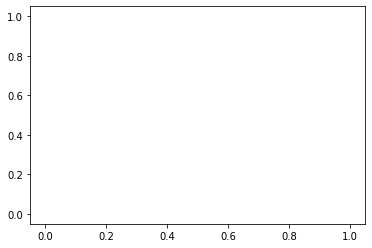

In [ ]:
# plt.plot(nb_fpr, nb_tpr, marker='.', label='Gaussian (AUROC = %0.3f)' % nb_auc)

In [ ]:
# X.shape

(16224, 24000)

In [ ]:
# fpr1, tpr1,thresh1 =roc_curve(y_test, pred_prob1[:,1],pos_label=1)

C:\Users\ANANDA CHATTERJEE\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


In [ ]:
# tpr1

array([nan, nan, nan])

In [ ]:
# import matplotlib.pyplot as plt

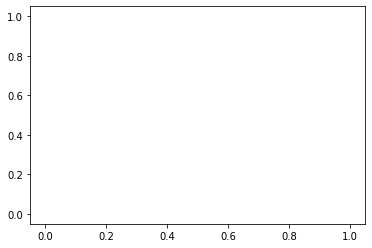

In [ ]:
# plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Gaussian')